In [1]:
%matplotlib inline
import sys
import os
DATA_PATH = os.getenv('DATA_PATH')
CODE_PATH = os.getenv('CODE_PATH')
FIGURE_PATH = os.getenv('FIGURE_PATH')

sys.path.insert(0, os.path.join(CODE_PATH))

import pandas as pd
import numpy as np
import json
import re

import time

from src.load import EGRID, BA_DATA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from calendar import month_abbr

import logging.config
logging.config.fileConfig(os.path.join(CODE_PATH, "src/logging.conf"))
logger = logging.getLogger(__name__)

cm_per_in = 0.393701
two_col_width = 17.8 * cm_per_in

os.makedirs(os.path.join(FIGURE_PATH, "main"), exist_ok=True)
os.makedirs(os.path.join(FIGURE_PATH, "si"), exist_ok=True)

In [2]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [6.99, 2.5]
plt.rcParams['grid.color'] = 'k'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.size'] = 10

import cmocean
cmap = cmocean.cm.cmap_d['phase']
COLORS = sns.color_palette('colorblind')

In [3]:
savePlots = False

In [4]:
def separate_imp_exp(data, ba):

    partners = data.get_trade_partners(ba)
    imp = 0.
    exp = 0.
    for ba2 in data.get_trade_partners(ba):
        imp += data.df.loc[:, data.KEY["ID"] % (ba,ba2)].apply(lambda x: min(x, 0))
        exp += data.df.loc[:, data.KEY["ID"] % (ba,ba2)].apply(lambda x: max(x, 0))
    normalization = data.df.loc[:, data.KEY["D"] % ba] + exp
    return imp, exp, normalization

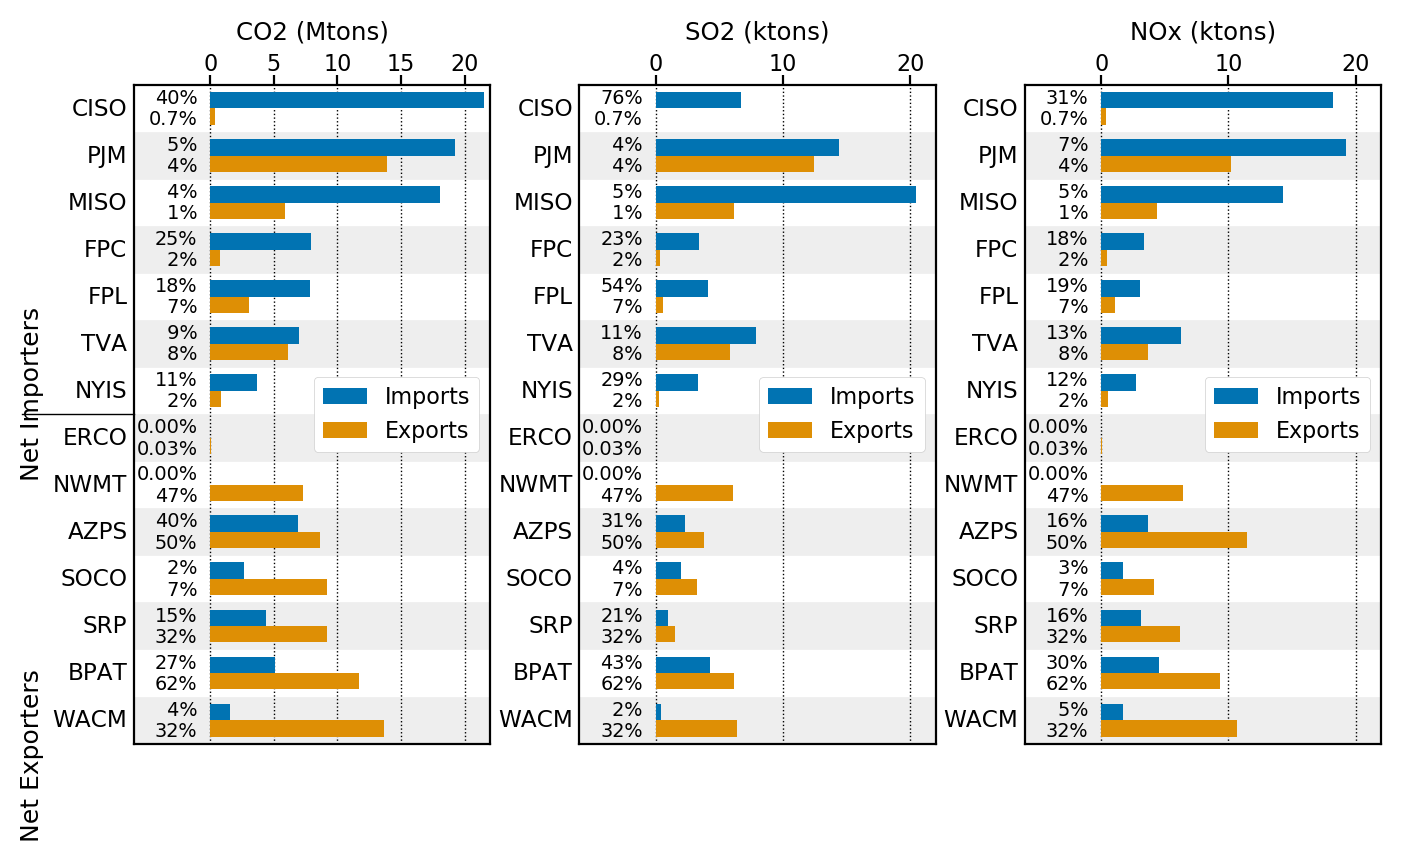

In [5]:
barWidth = 0.7
margin = 0.01

co2 = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_CO2_Y.csv"), variable="CO2")
so2 = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_SO2_Y.csv"), variable="SO2")
nox = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_NOX_Y.csv"), variable="NOX")

# Custom selection of exporters and importers
exporters = ['WACM', 'BPAT', 'SRP', 'SOCO', 'AZPS', 'NWMT', 'ERCO']
importers = ['NYIS', 'TVA', 'FPL', 'FPC', 'MISO', 'PJM', 'CISO']
regions = exporters + importers

n = len(regions)

f, axes = plt.subplots(1,3, figsize=(two_col_width, 3.7))

for ax, poll, scaling, xlabel, xlim, min_size_for_text, xticks in zip(
    axes, [co2, so2, nox], [1e-6, 1e-3, 1e-3],
    ["CO2 (Mtons)", "SO2 (ktons)", "NOx (ktons)"],
    [[-6, 22], [-6, 22], [-6, 22]],
    [8, 6, 6],
    [[0, 5, 10, 15, 20], [0, 10, 20], False]):
    bgcolor = "#eeeeee"
    color = COLORS[0] #"#777777"
    color2 = COLORS[1] #"#bbbbbb"
    df = poll.df
    df.index = [2016]

    for iba, ba in enumerate(regions):
        imp, exp, norm = separate_imp_exp(poll, ba)


        ax.barh(iba+barWidth/4, -imp.values * scaling,
                color=color, height=barWidth/2, zorder=3)
        ax.barh(iba-barWidth/4, exp.values * scaling,
                color=color2, height=barWidth/2, zorder=3)

        ha='right'
        va = 'center'
        x = -1
        def myformat(n):
            if n>1.:
                return "%2.0f%%" % n
            if n>0.1:
                return "%2.1f%%" % n
            else:
                return "%2.2f%%" % n
        ax.text(x,iba+barWidth/4+.05,
                myformat(-(imp.values/norm).values[0]*100+0.),
                fontsize="x-small", ha=ha, va=va)
        ax.text(x,iba-barWidth/4-.05,
                myformat((exp/norm).values[0]*100+0.),
                fontsize="x-small", ha=ha, va=va)
        ax.text(-6.5,iba, ba, ha=ha, va=va, fontsize="small")
        if iba % 2 == 0:
            ax.axhspan(iba-.5, iba+.5, color=bgcolor)
#         ax.axhline(iba+.5, color='k')
        
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(xlabel)
    ax.set_xlim(xlim)    
    ax.set_ylim([-.5, n-.5])
    ax.set_yticks(range(len(exporters+importers)))
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.yaxis.grid(False)
    if xticks:
        ax.set_xticks(xticks)
    ax.set_yticklabels([]);
    
    # legend
    ax.barh([-10], [1], color=color, height=barWidth/2, zorder=3,
            label="Imports")
    ax.barh([-10], [1], color=color2, height=barWidth/2, zorder=3,
            label="Exports")

    ax.legend(loc='center right', framealpha=1.)
    
    ax.xaxis.labelpad = 5
    ax.tick_params(axis='x', which='major', pad=0)

axes[0].text(-14, .6*n, "Net Importers",
             ha='center', rotation=90, fontsize=9)
axes[0].text(-14, .05*n, "Net Exporters",
             ha='center', rotation=90, fontsize=9)

line = matplotlib.lines.Line2D(
    (0.02, .1), (.455, .455), zorder=3, transform=f.transFigure, color='k', lw=.5)
f.lines.append(line)



plt.subplots_adjust(left=0.1, bottom=0.01, right=.99, top=.9, wspace=.25)

if savePlots:
    f.savefig(os.path.join(FIGURE_PATH, 'main/fig4.pdf'))
